In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import xgboost as xgb  #GBM algorithm
from xgboost import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   # Perforing grid search

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('data/new_train.csv')
test_data = pd.read_csv('data/new_test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

(1460, 271)


,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,SalePrice
0,0.474666,0.400731,1.0,0.0,1.0,0.875,0.625,0.35108,0.693147,0.510826,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,12.247699


(1459, 270)


,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
0,0.55828,0.517572,1.0,0.0,1.0,0.625,0.75,0.0,0.510826,0.510826,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1461


In [3]:
import math

def common_num_range(start,stop,step):
    
    startlen = stoplen = steplen = 0
    if '.' in str(start):
        startlen = len(str(start)) - str(start).index('.') - 1
    if '.' in str(stop):
        stoplen = len(str(stop)) - str(stop).index('.') - 1
    if '.' in str(step):
        steplen = len(str(step)) - str(step).index('.') - 1
    
    maxlen = startlen
    if stoplen > maxlen:
        maxlen = stoplen
    if steplen > maxlen:
        maxlen = steplen
    
    power = math.pow(10, maxlen)
    
    if startlen == 0 and stoplen == 0 and steplen == 0:
        return range(start, stop, step)
    else:
        return [num / power for num in range(int(start*power), int(stop*power), int(step*power))]


In [4]:
train_id = train_data['Id']
train_Y = train_data['SalePrice']
train_data.drop(['Id', 'SalePrice'], axis=1, inplace=True)
train_X = train_data

test_Id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_X = test_data

In [5]:
# formatting for xgb
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X)

# XGBoost  & Parameter Tuning

Ref: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

## Parameters Tuning Plan

The overall parameters can be divided into 3 categories:

1. General Parameters: Guide the overall functioning
2. Booster Parameters: Guide the individual booster (tree/regression) at each step
3. Learning Task Parameters: Guide the optimization performed

In `XGBRegressor`:
```
class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
```

In [6]:
# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
def model_cross_validate(xgb_regressor, cv_paramters, dtrain, cv_folds = 5,
              early_stopping_rounds = 50, perform_progress=False):
    """
    xgb model cross validate to choose best param from giving cv_paramters.
    
    @param cv_paramters:dict,where to choose best param. {'param':[1,2,3]}
    @param dtrain:xgboost.DMatrix, training data formatted for xgb
    @param early_stopping_rounds: Activates early stopping.Stop when perfomance 
                                  does not improve for some rounds
    """
    # get initial parameters
    xgb_param = xgb_regressor.get_xgb_params()
    
    # save best param
    best_params = {}
    best_cvresult = None
    min_mean_rmse = float("inf")
    
    for param, values in cv_paramters.items():
        print '===========Tuning paramter:',param,'==========='
        best_param = values[0]
        for value in values:
            # set the param's value
            xgb_param[param] = value
            
            # cv to tune param from values
            cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=early_stopping_rounds)

            # calcuate the mean of several final rmses
            round_count = cvresult.shape[0]
            mean_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-mean'].mean()
            
            if perform_progress:
                std_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-std'].mean()

                if isinstance(value, int):
                    print "%s=%d CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)
                else:
                    print "%s=%f CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)
            
            if mean_rmse < min_mean_rmse:
                best_param = value
                best_cvresult = cvresult
                min_mean_rmse = mean_rmse
        
        best_params[param] = best_param
        print "best ", param, " = ", best_params[param]
    
    return best_params, min_mean_rmse, best_cvresult


In [8]:
def model_fit(xgb_regressor, train_x, train_y, performCV=True, 
              printFeatureImportance=True, cv_folds=5):
    
    # Perform cross-validation
    if performCV:
        xgb_param = xgb_regressor.get_xgb_params()
        cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=50)
        round_count = cvresult.shape[0]
        mean_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-mean'].mean()
        std_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-std'].mean()
        
        print "CV RMSE : Mean = %.7g | Std = %.7g" % (mean_rmse, std_rmse)
        
    # fir the train data
    xgb_regressor.fit(train_x, train_y)
    
    # Predict training set
    train_predictions = xgb_regressor.predict(train_x)
    mse = rmse(train_y, train_predictions)
    print("Train RMSE: %.7f" % mse)
    
    # Print Feature Importance
    if printFeatureImportance:
        feature_importances = pd.Series(xgb_regressor.feature_importances_, train_x.columns.values)
        feature_importances = feature_importances.sort_values(ascending=False)
        feature_importances= feature_importances.head(40)
        feature_importances.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    return xgb_regressor, feature_importances

Baseline XGBRegressor

CV RMSE : Mean = 0.1233299 | Std = 0.02001477
Train RMSE: 0.0826445


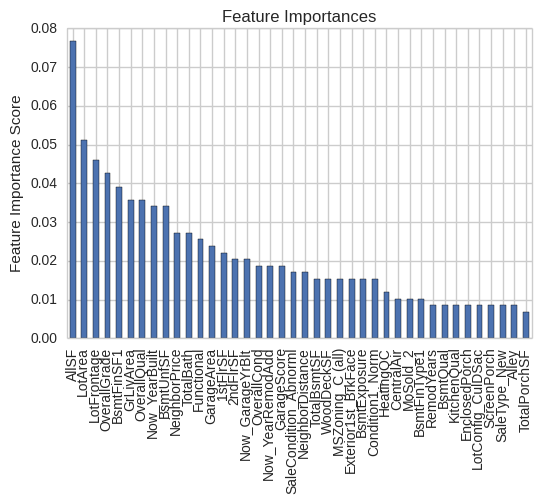

In [9]:
xgb_regressor = XGBRegressor(seed=10)
xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 1. Choose a relatively high learning_rate,optimum n_estimators

In [13]:
param_test = {'n_estimators':range(300,400,10)}

xgb_regressor = XGBRegressor(
                learning_rate =0.1,

                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

===========Tuning paramter: n_estimators ===========
n_estimators=300 CV RMSE : Mean = 0.1187436 | Std = 0.01769183
n_estimators=310 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
n_estimators=320 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
n_estimators=330 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
n_estimators=340 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
n_estimators=350 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
n_estimators=360 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
n_estimators=370 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
n_estimators=380 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
n_estimators=390 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
best  n_estimators  =  310
best params: {'n_estimators': 310}
min_mean_rmse: 0.118653509091


CV RMSE : Mean = 0.1186535 | Std = 0.01771516
Train RMSE: 0.0171113


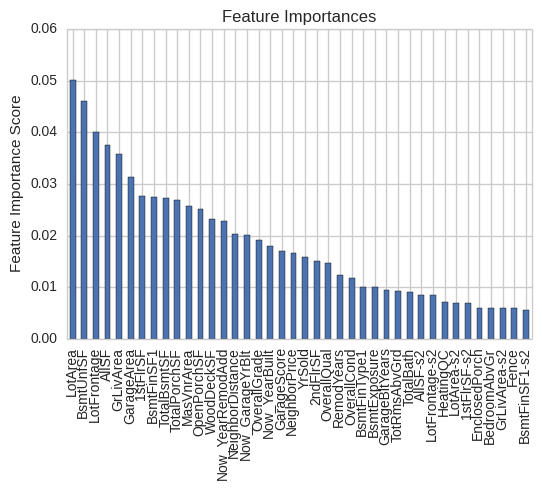

In [14]:
xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
    
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 2.Fix learning rate and number of estimators for tuning tree-based parameters

Tune `max_depth` and `min_child_weight`

In [15]:
param_test = {'max_depth':range(1,6,1),
               'min_child_weight':common_num_range(1,2,0.1)}

xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

===========Tuning paramter: max_depth ===========
max_depth=1 CV RMSE : Mean = 0.127297 | Std = 0.01905945
max_depth=2 CV RMSE : Mean = 0.1198763 | Std = 0.01718473
max_depth=3 CV RMSE : Mean = 0.11856 | Std = 0.01640916
max_depth=4 CV RMSE : Mean = 0.1206862 | Std = 0.01680033
max_depth=5 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
best  max_depth  =  3
===========Tuning paramter: min_child_weight ===========
min_child_weight=1.000000 CV RMSE : Mean = 0.1186535 | Std = 0.01771516
min_child_weight=1.100000 CV RMSE : Mean = 0.1190507 | Std = 0.0165949
min_child_weight=1.200000 CV RMSE : Mean = 0.1190507 | Std = 0.0165949
min_child_weight=1.300000 CV RMSE : Mean = 0.1190507 | Std = 0.0165949
min_child_weight=1.400000 CV RMSE : Mean = 0.1190507 | Std = 0.0165949
min_child_weight=1.500000 CV RMSE : Mean = 0.1190507 | Std = 0.0165949
min_child_weight=1.600000 CV RMSE : Mean = 0.1190507 | Std = 0.0165949
min_child_weight=1.700000 CV RMSE : Mean = 0.1190507 | Std = 0.0165949
min_child_weigh

CV RMSE : Mean = 0.11856 | Std = 0.01640916
Train RMSE: 0.0513473


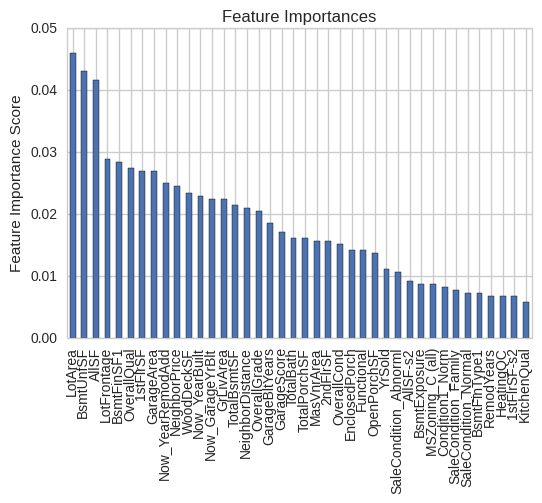

In [16]:
xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
                max_depth=3,
                min_child_weight=1,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Tune `gamma`,Minimum loss reduction required to make a further partition on a leaf node of the tree. 

In [17]:
param_test = {'gamma':[0, 0.1, 0.01, 0.001,0.0001, 0.00001]}

xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
                max_depth=3,
                min_child_weight=1,
    
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

===========Tuning paramter: gamma ===========
gamma=0 CV RMSE : Mean = 0.11856 | Std = 0.01640916
gamma=0.100000 CV RMSE : Mean = 0.1224133 | Std = 0.01754528
gamma=0.010000 CV RMSE : Mean = 0.1183788 | Std = 0.01716974
gamma=0.001000 CV RMSE : Mean = 0.1185646 | Std = 0.0169295
gamma=0.000100 CV RMSE : Mean = 0.118318 | Std = 0.01660462
gamma=0.000010 CV RMSE : Mean = 0.118581 | Std = 0.01641429
best  gamma  =  0.0001
best params: {'gamma': 0.0001}
min_mean_rmse: 0.118318018182


CV RMSE : Mean = 0.118318 | Std = 0.01660462
Train RMSE: 0.0513027


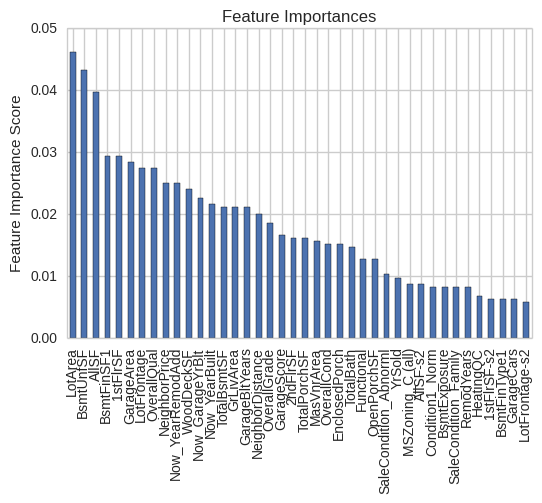

In [18]:
xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
                max_depth=3,
                min_child_weight=1,
                gamma=0.0001,
    
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Tune `subsample` and `colsample_bytree`

- subsample : Subsample ratio of the training instance.
- colsample_bytree : Subsample ratio of columns when constructing each tree

In [19]:
param_test = {'subsample':common_num_range(0.6, 0.9, 0.01),
               'colsample_bytree':common_num_range(0.6, 0.9, 0.01)}

xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
                max_depth=3,
                min_child_weight=1,
                gamma=0.0001,
    
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

===========Tuning paramter: subsample ===========
subsample=0.600000 CV RMSE : Mean = 0.1222929 | Std = 0.01819121
subsample=0.610000 CV RMSE : Mean = 0.1210595 | Std = 0.01780862
subsample=0.620000 CV RMSE : Mean = 0.1201475 | Std = 0.01906596
subsample=0.630000 CV RMSE : Mean = 0.1218958 | Std = 0.01795952
subsample=0.640000 CV RMSE : Mean = 0.1213038 | Std = 0.02008226
subsample=0.650000 CV RMSE : Mean = 0.1191674 | Std = 0.02061889
subsample=0.660000 CV RMSE : Mean = 0.1178984 | Std = 0.01922598
subsample=0.670000 CV RMSE : Mean = 0.1191956 | Std = 0.01903048
subsample=0.680000 CV RMSE : Mean = 0.1197684 | Std = 0.01909049
subsample=0.690000 CV RMSE : Mean = 0.1199656 | Std = 0.01918079
subsample=0.700000 CV RMSE : Mean = 0.1211669 | Std = 0.01975538
subsample=0.710000 CV RMSE : Mean = 0.1197079 | Std = 0.01901802
subsample=0.720000 CV RMSE : Mean = 0.1192464 | Std = 0.01871078
subsample=0.730000 CV RMSE : Mean = 0.1203352 | Std = 0.01989034
subsample=0.740000 CV RMSE : Mean = 0.11

CV RMSE : Mean = 0.1189812 | Std = 0.01851401
Train RMSE: 0.0535124


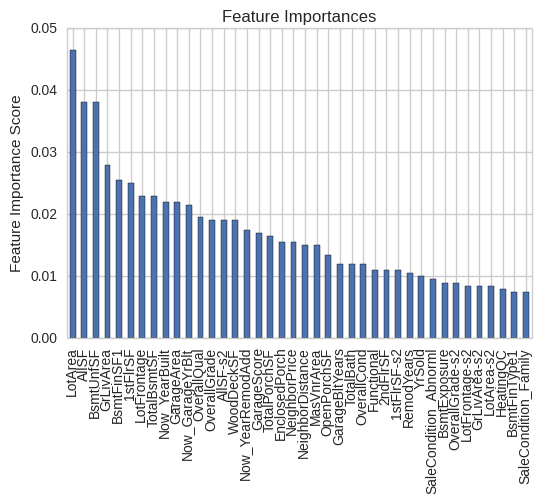

In [20]:
xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
                max_depth=3,
                min_child_weight=1,
                gamma=0.0001,
                subsample=0.66,
                colsample_bytree=0.6,
    
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

In [21]:
param_test2 = {'reg_lambda':common_num_range(0, 0.5, 0.01),
               'reg_alpha':common_num_range(0, 0.5, 0.01)}

xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
                max_depth=3,
                min_child_weight=1,
                gamma=0.0001,
                subsample=0.66,
                colsample_bytree=0.6,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test2, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

===========Tuning paramter: reg_lambda ===========
reg_lambda=0.000000 CV RMSE : Mean = 0.1229909 | Std = 0.02052107
reg_lambda=0.010000 CV RMSE : Mean = 0.1227057 | Std = 0.01973735
reg_lambda=0.020000 CV RMSE : Mean = 0.1219503 | Std = 0.01902635
reg_lambda=0.030000 CV RMSE : Mean = 0.1202458 | Std = 0.02015802
reg_lambda=0.040000 CV RMSE : Mean = 0.1217169 | Std = 0.01983744
reg_lambda=0.050000 CV RMSE : Mean = 0.1212981 | Std = 0.02054087
reg_lambda=0.060000 CV RMSE : Mean = 0.1196927 | Std = 0.01888885
reg_lambda=0.070000 CV RMSE : Mean = 0.1192592 | Std = 0.01950876
reg_lambda=0.080000 CV RMSE : Mean = 0.1207171 | Std = 0.02041765
reg_lambda=0.090000 CV RMSE : Mean = 0.1186134 | Std = 0.01960546
reg_lambda=0.100000 CV RMSE : Mean = 0.1200314 | Std = 0.02063713
reg_lambda=0.110000 CV RMSE : Mean = 0.1204104 | Std = 0.0203206
reg_lambda=0.120000 CV RMSE : Mean = 0.1212676 | Std = 0.01897889
reg_lambda=0.130000 CV RMSE : Mean = 0.1190431 | Std = 0.01873947
reg_lambda=0.140000 CV RMS

CV RMSE : Mean = 0.1165616 | Std = 0.01968105
Train RMSE: 0.0601677


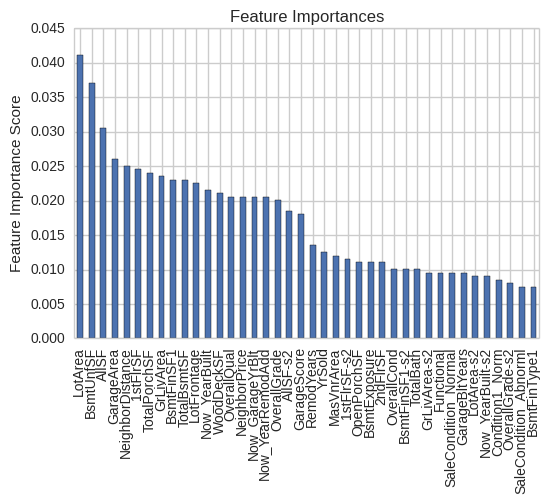

In [22]:
xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators = 310,
                max_depth=3,
                min_child_weight=1,
                gamma=0.0001,
                subsample=0.66,
                colsample_bytree=0.6,
                reg_lambda = 0.34,
                reg_alpha = 0.34,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)                                           

Paramters Micro-tuning

CV RMSE : Mean = 0.1160963 | Std = 0.01967199
Train RMSE: 0.0701128


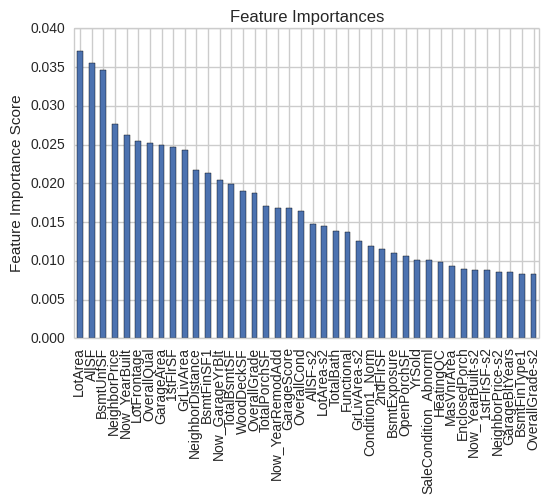

In [28]:
xgb_regressor = XGBRegressor(
                learning_rate =0.01,
                n_estimators = 2000,
                max_depth=3,
                min_child_weight=1,
                gamma=0.0001,
                subsample=0.66,
                colsample_bytree=0.6,
                reg_lambda = 0.34,
                reg_alpha = 0.34,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Final paramters:

```
xgb_regressor = XGBRegressor(
                learning_rate =0.01,
                n_estimators = 2000,
                max_depth=3,
                min_child_weight=1,
                gamma=0.0001,
                subsample=0.66,
                colsample_bytree=0.6,
                reg_lambda = 0.34,
                reg_alpha = 0.34,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)
```

In [29]:
xgb_predictions = xgb_regressor.predict(test_X)
xgb_predictions = np.power(np.e, xgb_predictions) - 1

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": xgb_predictions
    })

submission.to_csv("result/xgb_param_tune_predictions_2_11.csv", index=False)

print "Done."

Done.


In [33]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm

gbm_regressor = GradientBoostingRegressor(
                learning_rate=0.09,
                n_estimators=180,
                max_depth=3, 
                max_features = 60,
                min_samples_leaf=1,
                min_samples_split=27,
                subsample = 0.82,
                random_state=10,
                verbose=0)

gbm_regressor.fit(train_X, train_Y)

gbm_predictions = gbm_regressor.predict(test_X)
gbm_predictions = np.power(np.e, gbm_predictions) - 1

Done.


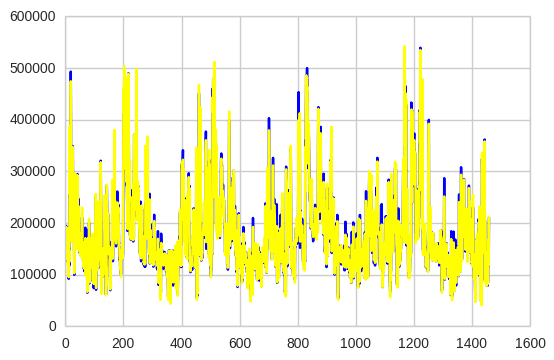

In [39]:
plt.plot(xgb_predictions, c="blue")
plt.plot(gbm_predictions, c="yellow")

In [36]:
predictions = (gbm_predictions + xgb_predictions) / 2
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": predictions
    })

submission.to_csv("result/xgb_gbm_param_tune_predictions_2_11.csv", index=False)

print "Done."

Done.
